In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths, coordinates_bounds, plot_feature_importances

In [5]:
def load_posts(input_path):
    df = pd.read_parquet(input_path)
    return df

In [6]:
if __name__ == "__main__":
    city = "manizales"
    property_type = "apartamentos"
    post_type = "venta"
    
    #city, property_type, post_type = check_args()
    base_path = os.environ.get('REPO')

    raw_path, clean_path = gen_paths(city, property_type, post_type)
    
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
MSG = """
Hay {} publicaciones de {} en total
"""

posts = load_posts(clean_path)
print(MSG.format(posts.shape[0], post_type))
posts.head()


Hay 3004 publicaciones de venta en total



,surface,rooms,baths,garages,price,latitude,description,longitude,location,url,admon,estrato,antiguedad,fid,city,property_type,post_type,price_m2
1,54.0,2.0,2.0,1.0,220.0,5.059000,"Apartamento ubicado cerca a Homecenter, constr...",-75.478996,Manizales La Toscana,https://www.fincaraiz.com.co/apartamento-en-ve...,0.0,4.0,1 a 8,5478594,manizales,apartamentos,venta,4.074074
2,72.0,3.0,3.0,1.0,280.0,5.043152,"Se cede apartamento 606 de la Torre 1 , 3 habi...",-75.473587,Manizales Avda Alberto Mendoza Frente a Expofe...,https://www.fincaraiz.com.co/apartamento-en-ve...,0.0,5.0,desconocido,5720132,manizales,apartamentos,venta,3.888889
3,160.0,4.0,3.0,1.0,290.0,5.050346,"Apartamento duplex, remodelado en La Camelia, ...",-75.484329,Manizales Palermo,https://www.fincaraiz.com.co/apartamento-en-ve...,300000.0,6.0,16 a 30,2870506,manizales,apartamentos,venta,1.812500
4,93.0,3.0,2.0,1.0,420.0,5.061000,"Bello y cómodo apartamento, ubicado sobre la A...",-75.490990,Manizales Av Santander,https://www.fincaraiz.com.co/apartamento-en-ve...,240000.0,6.0,1 a 8,5288572,manizales,apartamentos,venta,4.516129
6,65.0,3.0,2.0,1.0,150.0,5.064650,Inmobiliaria Giraldo Castaño ofrece apartament...,-75.507553,Manizales palonegro,https://www.fincaraiz.com.co/apartamento-en-ve...,0.0,3.0,1 a 8,5149671,manizales,apartamentos,venta,2.307692


## Es necesario cambiar la representación de algunas de las columnas


In [8]:
## La antiguedad tiene 5 posibles valores pero se representa con un string, la idea es usar un entero en cambio

antiguedades = posts["antiguedad"].value_counts().index
new_antiguedades = {}
for i in range(len(antiguedades)):
    new_antiguedades[antiguedades[i]] = i
new_antiguedades

{'desconocido': 0, '1 a 8': 1, '16 a 30': 2, '9 a 15': 3, 'Más de 30': 4}

In [9]:
posts.loc[:, "antiguedad"] = posts["antiguedad"].apply(lambda e: new_antiguedades[e])

In [10]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = [
    'surface', 'rooms', 
    'baths', 'garages', 'latitude', 
    'longitude', 'admon', 
    'estrato','antiguedad'
]

LABEL = "price"

X = posts[FEATURES].values
y = posts[LABEL].values

## Selección de features univariada

In [11]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

(3004, 5)

In [12]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

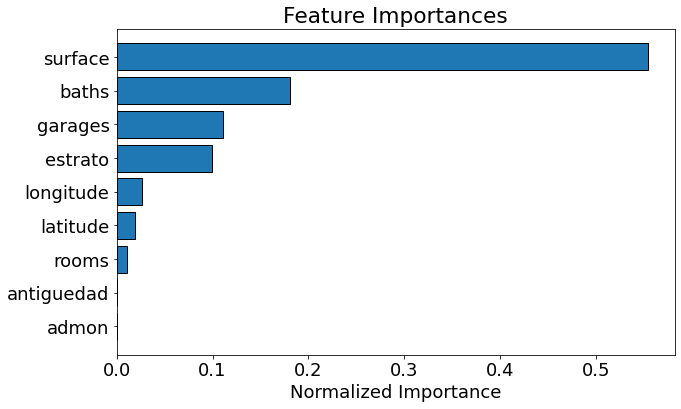

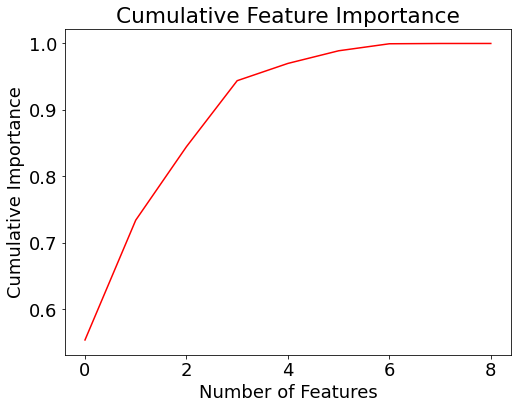

4 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,4438.027178,surface,0.553854,0.553854
1,2,1444.274889,baths,0.180242,0.734095
2,3,886.195468,garages,0.110595,0.844690
3,7,795.605565,estrato,0.099289,0.943979
4,5,208.270343,longitude,0.025992,0.969971
5,4,152.394189,latitude,0.019018,0.988989
6,1,84.614802,rooms,0.010560,0.999549
7,8,3.335668,antiguedad,0.000416,0.999965
8,6,0.277474,admon,0.000035,1.000000


In [13]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [15]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.6682518642128962

In [16]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [17]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

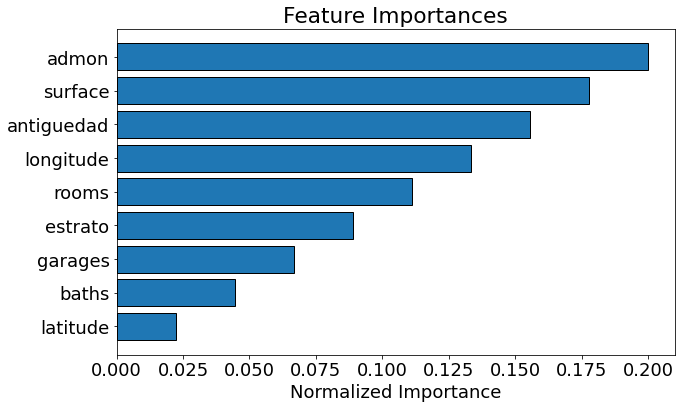

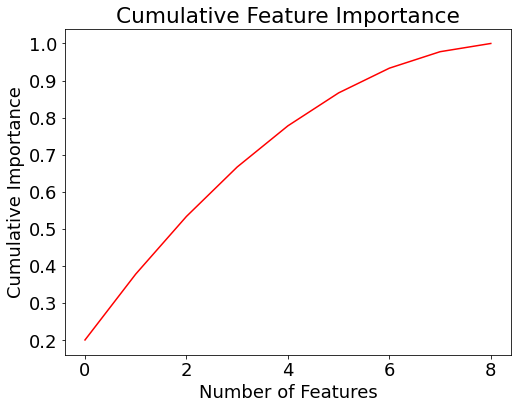

7 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,6,9,admon,0.200000,0.200000
1,0,8,surface,0.177778,0.377778
2,8,7,antiguedad,0.155556,0.533333
3,5,6,longitude,0.133333,0.666667
4,1,5,rooms,0.111111,0.777778
5,7,4,estrato,0.088889,0.866667
6,3,3,garages,0.066667,0.933333
7,2,2,baths,0.044444,0.977778
8,4,1,latitude,0.022222,1.000000


In [18]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

In [20]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [21]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

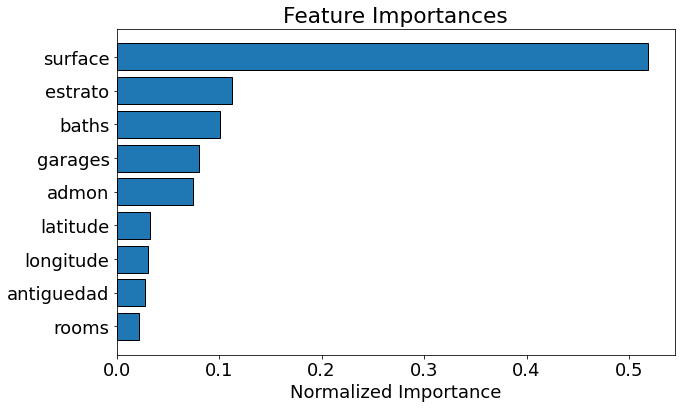

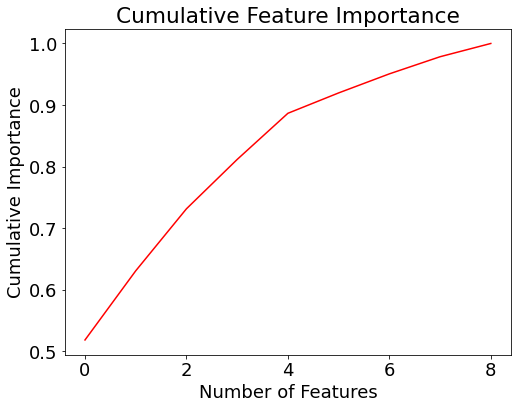

6 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,0.518410,surface,0.518410,0.518410
1,7,0.112309,estrato,0.112309,0.630719
2,2,0.100750,baths,0.100750,0.731469
3,3,0.080152,garages,0.080152,0.811621
4,6,0.074973,admon,0.074973,0.886594
5,4,0.033087,latitude,0.033087,0.919680
6,5,0.030951,longitude,0.030951,0.950631
7,8,0.027824,antiguedad,0.027824,0.978455
8,1,0.021545,rooms,0.021545,1.000000


In [22]:
plot_feature_importances(feature_importances)